# A numerical study of fixation probabilities for strategies in the Prisoners  Dilemma

This notebook contains all the Python code used to generate the plots and figures for the paper.

Here are the versions of the various libraries used:

In [2]:
%matplotlib inline

import axelrod as axl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import imp
players = imp.load_source('players', '../src/players.py')

assert axl.__version__ == '2.9.0' 
assert pd.__version__ == '0.19.2'
assert matplotlib.__version__ == '2.0.0'
assert sns.__version__ == '0.7.1'

## Description of the used strategies

Here are all the strategies used in this experiment:

In [3]:
from players import selected_players
players = selected_players()

In [4]:
players

[Evolved FSM 4, Evolved FSM 16, Evolved FSM 16 Noise 05]

In [4]:
with open("../tbl/list_of_players.tex", "w") as f:
    for player in players:
        latex_name = "{}\n".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))

Here are some summary information about the strategies

In [5]:
def clean_mem(n):
    try:
        return int(n)
    except OverflowError:
        return -1

df = pd.DataFrame([[p, p.classifier["stochastic"], clean_mem(p.classifier['memory_depth'])] 
                   for p in players], 
                  columns=["Player", "Stochastic", "Memory Depth"])

In [6]:
t_df = pd.DataFrame(df.groupby("Stochastic")["Player"].count()).reset_index().rename(columns={"Player": "Count"})
t_df

,Stochastic,Count
0,False,3


In [7]:
with open("../tbl/stochastic_count.tex", "w") as f:
    f.write(t_df.to_latex(index=False))

In [8]:
t_df = pd.DataFrame(df.groupby("Memory Depth")["Player"].count()).transpose()
t_df.rename(index={"Player": "Count"}, inplace=True)
cols = t_df.columns.tolist()
t_df = t_df[cols[1:] + [cols[0]]]
t_df

Memory Depth,16,4
Count,2,1


In [9]:
with open("../tbl/memory_depth_count.tex", "w") as f:
    string = t_df.to_latex().replace("-1", "\(\infty\)")
    f.write(string)

## Illustrating the Approximate moran process

In [10]:
df = pd.read_csv("../data/outcomes.csv", header=None, names=["Player 1", "Player 2", 
                                                             "Score 1", "Score 2", 
                                                             "Iteration"])

Get the counts of each number of 

In [11]:
t_df = pd.DataFrame(df.groupby(["Player 1", "Player 2"]).count()).reset_index()

In [12]:
max_pair = t_df.iloc[t_df["Score 1"].idxmax()][:2]
max_pair

Player 1    Evolved FSM 16
Player 2    Evolved FSM 16
Name: 0, dtype: object

In [13]:
min_pair = t_df.iloc[t_df["Score 1"].idxmin()][:2]
min_pair

Player 1    Evolved FSM 16
Player 2    Evolved FSM 16
Name: 0, dtype: object

/home/vince/anaconda3/envs/moran/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4237: RuntimeWarning: divide by zero encountered in double_scalars
  sy = (ymax - ymin) / ny
/home/vince/anaconda3/envs/moran/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4340: RuntimeWarning: invalid value encountered in multiply
  offsets[:, 1] *= sy


TypeError: len() of unsized object

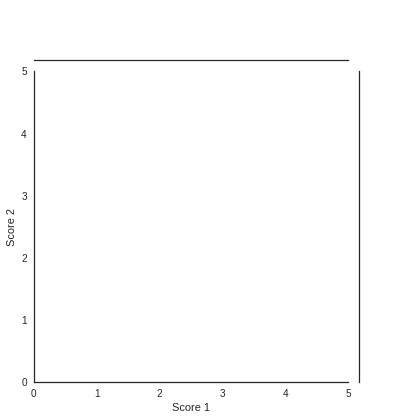

In [14]:
t_df = df[(df["Player 1"] == max_pair[0]) & (df["Player 2"] == max_pair[1])]

def N(x, y):
    return len(x)

sns.set(style="white", color_codes=True)
ax = sns.jointplot(t_df["Score 1"], t_df["Score 2"], stat_func=N, 
                   kind="hex", xlim=(0, 5), ylim=(0,5))
ax.set_axis_labels(*["\'{}\' score".format(max_pair[i]) for i in range(2)])
ax.savefig("../img/players_with_most_scores.pdf");

In [15]:
len(t_df["Score 1"])

1